In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vector-borne-disease-prediction/testt.csv
/kaggle/input/vector-borne-disease-prediction/trainn.csv
/kaggle/input/playground-series-s3e13/sample_submission.csv
/kaggle/input/playground-series-s3e13/train.csv
/kaggle/input/playground-series-s3e13/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, make_scorer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA, NMF
from sklearn.model_selection import learning_curve
from sklearn.manifold import TSNE
from umap import UMAP
from scipy.cluster.hierarchy import dendrogram, ward
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)

In [3]:
train = pd.read_csv(r'../input/playground-series-s3e13/train.csv')
test_1 = pd.read_csv(r'../input/playground-series-s3e13/test.csv')
orig_train = pd.read_csv(r'../input/vector-borne-disease-prediction/trainn.csv')

train.drop('id', axis = 1, inplace = True)
test = test_1.drop('id', axis = 1)

In [4]:
combo_train = pd.concat([train, orig_train])
print(f'There are {combo_train.duplicated(subset = list(train)[0:-1]).value_counts()[0]} non-duplicate values out of {combo_train.count()[0]} rows in original train dataset')

There are 959 non-duplicate values out of 959 rows in original train dataset


In [5]:
X = combo_train.copy()
y = X.pop('prognosis')

#Fix the issues that the original data set used "-"to separate the words
y = [prognosis.replace(' ', '_') for prognosis in y]

In [6]:
#Cross validation strategy
seed = 42
splits = 10
cv = RepeatedStratifiedKFold(n_splits = splits, n_repeats = 5, random_state = seed)
#cv = StratifiedKFold(n_splits = splits, random_state = seed, shuffle = True)

np.random.seed(seed)

In [7]:
def apk(actual, predicted, k=10):
    
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)


def mapk(actual, predicted, k=10):
    
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [8]:
def cross_val_pipe(model, train = train, target ='prognosis', cv = cv, label = ''):
    
    X = train.copy()
    y = X.pop(target)
    
    #creating encoder and transforming prognosis
    enc = LabelEncoder()
    y = enc.fit_transform(y)
    
    #initiate prediction arrays and score lists
    val_predictions = np.zeros((len(train), 11)) # Validation predictions are stored in a matrix with length of the number of trainijng samples and # of preds
    train_predictions = np.zeros((len(train), 11)) # Same for the train predictions
    train_logloss, val_logloss = [], [] #Store the results from the log_loss calc in a list
    train_map3, val_map3 = [], [] #Store the results from the log_loss calc in a list
    
    #training model, predicting prognosis probability, and evaluating log loss
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
                
        model.fit(X.iloc[train_idx], y[train_idx])
        
        train_preds = model.predict_proba(X.iloc[train_idx])
        val_preds = model.predict_proba(X.iloc[val_idx])
                  
        train_predictions[train_idx] += train_preds
        val_predictions[val_idx] += val_preds
        
        train_score = log_loss(y[train_idx], train_preds)
        val_score = log_loss(y[val_idx], val_preds)
        
        train_logloss.append(train_score)
        val_logloss.append(val_score)
        
        #select three most probable prognosis based on train dataset prediction
        train_index = np.argsort(-train_preds)[:,:3] #return index of three most probable prognosis
        
        #select three most probable prognosis based on validation dataset prediction
        val_index = np.argsort(-val_preds)[:,:3]
    
        #calculate map@3
        train_score = mapk(y[train_idx].reshape(-1, 1), train_index, 3)
        val_score = mapk(y[val_idx].reshape(-1, 1), val_index, 3)
        
        train_map3.append(train_score)
        val_map3.append(val_score)
    
    print(f'Val log_loss   : {np.mean(val_logloss):.5f} | Train log_loss   : {np.mean(train_logloss):.5f} | {label}')
    print(f'Val MAP@3 Score: {np.mean(val_map3):.5f} | Train MAP@3 Score: {np.mean(train_map3):.5f} | {label}\n')
    
    return val_logloss, val_map3

In [9]:
def cross_val_score(model, cv = cv, label = ''):
    
    X = train.copy()
    y = X.pop('prognosis')
    
    #creating encoder and transforming prognosis
    enc = LabelEncoder()
    y = enc.fit_transform(y)
    
    #initiate prediction arrays and score lists
    val_predictions = np.zeros((len(train), 11)) # Validation predictions are stored in a matrix with length of the number of trainijng samples and # of preds
    train_predictions = np.zeros((len(train), 11)) # Same for the train predictions
    train_logloss, val_logloss = [], [] #Store the results from the log_loss calc in a list
    train_map3, val_map3 = [], [] #Store the results from the log_loss calc in a list
    
    #training model, predicting prognosis probability, and evaluating log loss
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
                
        model.fit(X.iloc[train_idx], y[train_idx])
        
        train_preds = model.predict_proba(X.iloc[train_idx])
        val_preds = model.predict_proba(X.iloc[val_idx])
                  
        train_predictions[train_idx] += train_preds
        val_predictions[val_idx] += val_preds
        
        train_score = log_loss(y[train_idx], train_preds)
        val_score = log_loss(y[val_idx], val_preds)
        
        train_logloss.append(train_score)
        val_logloss.append(val_score)
        
        #select three most probable prognosis based on train dataset prediction
        train_index = np.argsort(-train_preds)[:,:3] #return index of three most probable prognosis
        
        #select three most probable prognosis based on validation dataset prediction
        val_index = np.argsort(-val_preds)[:,:3]
    
        #calculate map@3
        train_score = mapk(y[train_idx].reshape(-1, 1), train_index, 3)
        val_score = mapk(y[val_idx].reshape(-1, 1), val_index, 3)
        
        train_map3.append(train_score)
        val_map3.append(val_score)
    
    print(f'Val log_loss   : {np.mean(val_logloss):.5f} | Train log_loss   : {np.mean(train_logloss):.5f} | {label}')
    print(f'Val MAP@3 Score: {np.mean(val_map3):.5f} | Train MAP@3 Score: {np.mean(train_map3):.5f} | {label}\n')
    
    return val_logloss, val_map3

In [10]:
#Classification models
models = [
    ('log', LogisticRegression(random_state = seed, max_iter = 10000)),
    ('svc', SVC(random_state = seed, probability = True)),
    #('lda', LinearDiscriminantAnalysis()),
    #('qda', QuadraticDiscriminantAnalysis()),
    ('gauss', GaussianProcessClassifier(random_state = seed)),
    ('et', ExtraTreesClassifier(random_state = seed)),
    ('rf', RandomForestClassifier(random_state = seed)),
    ('xgb', XGBClassifier(random_state = seed, objective = 'multi:softprob', eval_metric = 'map@3')),
    ('lgb', LGBMClassifier(random_state = seed, objective = 'softmax', metric = 'softmax')),
    ('dart', LGBMClassifier(random_state = seed, objective = 'softmax', metric = 'softmax', boosting_type = 'dart')),
    ('cb', CatBoostClassifier(random_state = seed, objective = 'MultiClass', verbose = 0)),
    ('gb', GradientBoostingClassifier(random_state = seed)),
    ('hgb', HistGradientBoostingClassifier(random_state = seed)),
    ('ada', AdaBoostClassifier(random_state = seed)),
    ('knn', KNeighborsClassifier())
]

In [11]:
# setting up the pipeline

### Execution

In [19]:
class Decomp:
    def __init__(self, n_components, method="pca", scaler_method='standard'):
        self.n_components = n_components
        self.method = method
        self.scaler_method = scaler_method
        
    def dimension_reduction(self, df):
            
        X_reduced = self.dimension_method(df)
        df_comp = pd.DataFrame(X_reduced, columns=[f'{self.method.upper()}_{_}' for _ in range(self.n_components)], index=df.index)
        
        return df_comp
    
    def dimension_method(self, df):
        X = self.scaler(df)
        if self.method == "pca":
            comp = PCA(n_components=self.n_components, random_state=0)
            X_reduced = comp.fit_transform(X)
        elif self.method == "nmf":
            comp = NMF(n_components=self.n_components, random_state=0)
            X_reduced = comp.fit_transform(X)
        elif self.method == "umap":
            comp = UMAP(n_components=self.n_components, random_state=0)
            X_reduced = comp.fit_transform(X)
        elif self.method == "tsne":
            comp = TSNE(n_components=self.n_components, random_state=0) # Recommend n_components=2
                  X_reduced = comp.fit_transform(X)
        else:
            raise ValueError(f"Invalid method name: {method}")
        
        self.comp = comp
        return X_reduced
    
    def scaler(self, df):
        
        _df = df.copy()
            
        if self.scaler_method == "standard":
            return StandardScaler().fit_transform(_df)
        elif self.scaler_method == "minmax":
            return MinMaxScaler().fit_transform(_df)
        elif self.scaler_method == None:
            return _df.values
        else:
            raise ValueError(f"Invalid scaler_method name")
        
    def get_columns(self):
        return [f'{self.method.upper()}_{_}' for _ in range(self.n_components)]
    
    def transform(self, df):
        X = self.scaler(df)
        X_reduced = self.comp.transform(X)
        df_comp = pd.DataFrame(X_reduced, columns=[f'{self.method.upper()}_{_}' for _ in range(self.n_components)], index=df.index)
        
        return df_comp
     @property
        
    def get_explained_variance_ratio(self):
        
        return np.sum(self.comp.explained_variance_ratio_)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 56)

In [12]:
train_sizes, train_scores, test_scores = learning_curve(estimator=LogisticRegression(random_state = seed, max_iter = 10000),
                             X=X,
                               y=y,
                                scoring = 'accuracy', 
                               train_sizes=np.linspace(
                                           0.1, 1.0, 10),
                               cv=10)

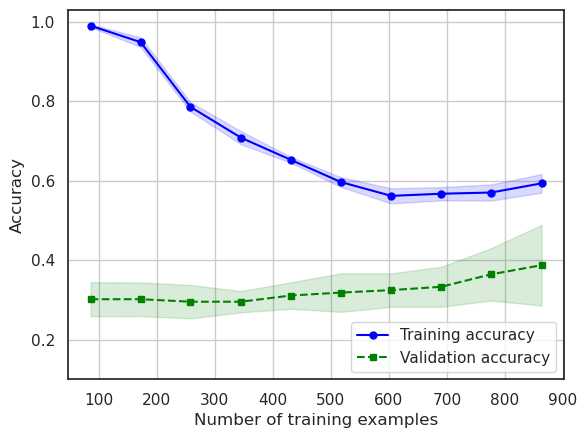

In [13]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean,
color='blue', marker='o',
          markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
train_mean + train_std,
train_mean - train_std,
 alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
color='green', linestyle='--',
marker='s', markersize=5,
label='Validation accuracy')
plt.fill_between(train_sizes,
test_mean + test_std,
test_mean - test_std,
alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.1, 1.03])
plt.show()

In [14]:
#Set up a logistic regression pipeline
#No feature engineering part 
model = make_pipeline(LogisticRegression(random_state = seed, max_iter = 10000))

In [15]:
#i = 0.2
#gen = train.sample(frac = i)
#cross_val_pipe(model = lr_pipe, train = gen,  target ='prognosis', cv = cv, label = '') 

In [16]:
for i in range(1,11):
    print(i/10)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


In [17]:
for i in range(,11,1):
    X = train.copy().sample(frac = i/10)
    y = X.pop("prognosis")
    print(X.shape, y.shape)

SyntaxError: invalid syntax (2397930912.py, line 1)

In [ ]:

for i in range(5,11,1):
    X = train.copy().sample(frac = i/10)
    y = X.pop("prognosis")
    
    #creating encoder and transforming prognosis
    enc = LabelEncoder()
    y = enc.fit_transform(y)
    
    #initiate prediction arrays and score lists
    val_predictions = np.zeros((len(X), 11)) # Validation predictions are stored in a matrix with length of the number of trainijng samples and # of preds
    train_predictions = np.zeros((len(X), 11)) # Same for the train predictions
    train_logloss, val_logloss = [], [] #Store the results from the log_loss calc in a list
    train_map3, val_map3 = [], [] #Store the results from the log_loss calc in a list
    
    #training model, predicting prognosis probability, and evaluating log loss
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
                
        model.fit(X.iloc[train_idx], y[train_idx])
        
        train_preds = model.predict_proba(X.iloc[train_idx])
        val_preds = model.predict_proba(X.iloc[val_idx])
                  
        train_predictions[train_idx] += train_preds
        val_predictions[val_idx] += val_preds
        
        train_score = log_loss(y[train_idx], train_preds)
        val_score = log_loss(y[val_idx], val_preds)
        
        train_logloss.append(train_score)
        val_logloss.append(val_score)
        
        #select three most probable prognosis based on train dataset prediction
        train_index = np.argsort(-train_preds)[:,:3] #return index of three most probable prognosis
        
        #select three most probable prognosis based on validation dataset prediction
        val_index = np.argsort(-val_preds)[:,:3]
    
        #calculate map@3
        train_score = mapk(y[train_idx].reshape(-1, 1), train_index, 3)
        val_score = mapk(y[val_idx].reshape(-1, 1), val_index, 3)
        
        train_map3.append(train_score)
        val_map3.append(val_score)
    
    print(f'Val log_loss  for {i} : {np.mean(val_logloss):.5f} | Train log_loss   : {np.mean(train_logloss):.5f}')
    print(f'Val MAP@3 Score for {i}: {np.mean(val_map3):.5f} | Train MAP@3 Score: {np.mean(train_map3):.5f}' )

In [ ]:
logloss_list, map3_list = pd.DataFrame(), pd.DataFrame()

for (label, model) in models: #Aha, the label in the print function comes from here, as the models had been setuo as a list of tuples
    (logloss_list[label], map3_list[label]) = cross_val_pipe(model, label = label)